In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
waveforms_filepath = '../waveforms.hdf5'
metadata_filepath = '../metadata.csv'

In [24]:
def data_reader(waveforms_filepath, trace_List):
    '''
    For each trace, this function appends a waveform into X and it's corresponding magnitude in y.
    Returns X as a 3D array and y as a 1D array
    '''
    
    hdf = h5py.File(waveforms_filepath, 'r')
    X = np.zeros([len(trace_List), 3000, 3])
    Y = np.zeros([len(trace_List), 1])
    
    for i, trace in enumerate(trace_List):
        dataset = hdf.get('earthquake/local/'+str(trace))
        data = np.array(dataset)
        p_arrival = int(dataset.attrs['p_arrival_sample'])
        magnitude = round(float(dataset.attrs['source_magnitude']), 2)
        
        cropped_data = data[p_arrival-100: p_arrival+2900, :] #30 secs
        X[i,:,:] = cropped_data
        Y[i,0] = magnitude
        
    hdf.close()
    
    return X, Y

In [5]:
def string_to_snr(string):
    '''
    This function takes as input a string with 3 space seperated values
    for SNR and converts them into float
    '''
    
    tempList = string.split()
    snr = []
    
    for counter, item in enumerate(tempList):
        '''
        Some are like '[56.79999924 55.40000153 47.40000153]'
        and some are '[ 56.79999924 55.40000153 47.40000153 ]'
        '''
        if item != '[' and item != ']':
            left = item.split('[')
            right = item.split(']')
            
            #if dealing with left most value
            if len(left) == 2:
                value = left[1]
            #if dealing with right most valie
            elif len(right) == 2:
                value = right[0]
            #if dealing with middle value
            elif len(left) == 1 and len(right) == 1:
                value = item
            else:
                pass
            try:
                value = float(value)
            except:
                value = None

            snr.append(value)
        
    return snr

In [43]:
df = pd.read_csv(metadata_filepath)

def reduce_size(df):
    '''
    Simply reducing the size of df and only fetching waveforms that start and end within 30 secs
    '''
    df = df[df['trace_category'] == 'earthquake_local']
    df = df[df['source_distance_km'] <= 20] #distance between epicenter and receiving station
    df = df[df['source_magnitude_type'] == 'ml'] #richter scale(local magnitude)
    df = df[df['p_arrival_sample'] >= 200] #all waveforms with p waves arrival at 2secs or onwards
    df = df[df['p_arrival_sample']+2900 <= 6000] #starts 1 sec before P wave arrival so 29 secs left after it for a total of 30secs
    df = df[df['coda_end_sample'] <= 3000] #at most 3000 sample
    df = df[df['p_travel_sec'].notnull()]
    df = df[df['p_travel_sec'] > 0]
    df = df[df['source_distance_km'].notnull()]
    df = df[df['source_distance_km'] > 0]
    df = df[df['source_depth_km'].notnull()]
    df = df[df['source_magnitude'].notnull()]
    #Calculating mean of snr values and replacing the values with mean in df
    df['snr_db'] = df['snr_db'].apply(lambda x: np.mean(string_to_snr(x)))
    df = df[df['snr_db'] >= 20]
    return df

df = reduce_size(df)
df

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
48,TA,109C,BH,32.8889,-117.1051,150.0,800.0,manual,0.64,3.68,...,CI,None,0.1734,19.28,284.1,33.766666,1506.0,2007-08-04 23:56:18.490000,earthquake_local,109C.TA_20070804235617_EV
578,TA,A04D,BH,48.7201,-122.7063,13.0,800.0,manual,1.00,3.00,...,None,None,0.1158,12.86,156.0,49.866666,1817.0,2013-05-22 13:48:01.220000,earthquake_local,A04D.TA_20130522134800_EV
646,TA,A04D,BH,48.7201,-122.7063,13.0,700.0,manual,0.92,4.33,...,None,None,0.1755,19.50,155.4,34.000001,1864.0,2015-02-12 13:10:12.720000,earthquake_local,A04D.TA_20150212131011_EV
691,TA,A04D,BH,48.7201,-122.7063,13.0,500.0,manual,1.00,3.41,...,None,None,0.1376,15.28,177.1,31.766667,1812.0,2015-09-23 00:15:50.870000,earthquake_local,A04D.TA_20150923001549_EV
692,TA,A04D,BH,48.7201,-122.7063,13.0,400.0,manual,1.00,3.28,...,None,None,0.1329,14.77,178.4,22.533333,1939.0,2015-09-30 10:56:54.230000,earthquake_local,A04D.TA_20150930105653_EV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031898,WY,YHL,HH,44.8509,-111.1830,2691.0,800.0,manual,0.64,4.00,...,None,None,0.1095,12.17,117.6,33.166667,1691.0,2017-06-21 08:12:33.610000,earthquake_local,YHL.WY_20170621081232_EV
1031899,WY,YHL,HH,44.8509,-111.1830,2691.0,900.0,manual,0.63,4.45,...,None,None,0.1286,14.30,119.0,36.666667,1797.0,2017-06-21 08:32:14.320000,earthquake_local,YHL.WY_20170621083213_EV
1031904,WY,YHL,HH,44.8509,-111.1830,2691.0,600.0,manual,0.65,4.84,...,None,None,0.1553,17.26,121.7,43.133334,1551.0,2017-06-21 12:21:05.390000,earthquake_local,YHL.WY_20170621122104_EV
1031905,WY,YHL,HH,44.8509,-111.1830,2691.0,500.0,manual,0.65,4.82,...,None,None,0.1534,17.05,121.5,43.366667,1443.0,2017-06-21 12:23:40.200000,earthquake_local,YHL.WY_20170621122339_EV


In [44]:
df[['p_arrival_sample', 's_arrival_sample', 'coda_end_sample']]

,p_arrival_sample,s_arrival_sample,coda_end_sample
48,800.0,1068.0,1506.0
578,800.0,1075.0,1817.0
646,700.0,1112.0,1864.0
691,500.0,768.0,1812.0
692,400.0,685.0,1939.0
...,...,...,...
1031898,800.0,1016.0,1691.0
1031899,900.0,1137.0,1797.0
1031904,600.0,867.0,1551.0
1031905,500.0,737.0,1443.0


In [45]:
unique_receiver_codes = df['receiver_code'].unique()

In [46]:
unique_receiver_codes

array(['109C', 'A04D', 'A14A', ..., 'YHB', 'YHH', 'YHL'], dtype=object)

In [47]:
len(unique_receiver_codes)

1064

In [48]:
#Finding Station receiver codes with 400 or more observations recorded
def required_stations(codes):
    multi_observations = []
    for i in range(0, len(codes)):
        count = sum(n == str(codes[i]) for n in df['receiver_code'])
        if count >= 400:
            multi_observations.append(codes[i])
    return multi_observations
  
mutli_observations = required_stations(unique_receiver_codes)

In [49]:
len(multi_observations)

43

In [50]:
np.save('assets/multi_observations', multi_observations)

In [51]:
multi_observations = np.load('assets/multi_observations.npy')

In [52]:
#Station receiver codes with 400 or more observations recorded
print(multi_observations)
print(len(multi_observations))

['AAM1' 'AAM2' 'AAM3' 'AHUD' 'B081' 'B082' 'B084' 'B086' 'B087' 'B093'
 'B916' 'B918' 'BOR' 'BZN' 'CCB' 'COLR' 'CRY' 'DESD' 'DNR' 'FRD' 'JRC2'
 'KAN01' 'KAN05' 'KAN06' 'KAN08' 'KAN10' 'KAN11' 'KAN12' 'KNW' 'KTH' 'LHV'
 'MPK' 'MT01' 'MT03' 'NV31' 'PAUD' 'RIMD' 'RSDD' 'RYN' 'TVH2' 'TVH3' 'UWE'
 'WAK']
43


In [53]:
def get_traces(multi_observations):
    '''
    Returns a list of traces corresponding to station codes in multi_observations
    '''
    trace_List = []
    for i in range(0,len(df)):
        code = df.iloc[i]['receiver_code']
        if code in multi_observations:
            trace_List.append(df.iloc[i]['trace_name'])
    return trace_List

trace_List = get_traces(multi_observations)

In [54]:
len(trace_List)

76234

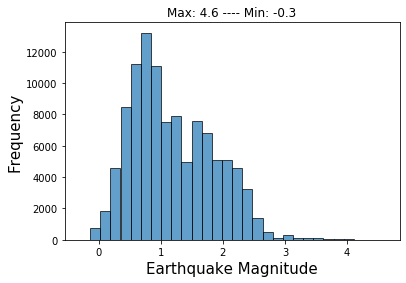

In [55]:
x = df['source_magnitude'].to_list()
plt.hist(x, bins=30, histtype='bar', alpha=0.7, ec='black')
plt.title('Max: ' + str(max(df['source_magnitude'])) + ' ---- Min: ' + str(min(df['source_magnitude'])))
plt.xlabel('Earthquake Magnitude',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.show()

In [56]:
#shuffling trace list
trace_List = np.array(trace_List)
np.random.shuffle(trace_List)

# first 70% data
training = trace_List[: int(0.7*len(trace_List))]

# between 70 and 80%
validation = trace_List[int(0.7*len(trace_List)) : int(0.8*len(trace_List))]

#last 20% data
test = trace_List[int(0.8*len(trace_List)) :]

In [59]:
print(len(training))
print(len(test))

53363
15247


In [60]:
X_train, y_train = data_reader(waveforms_filepath, training) 
X_test, y_test = data_reader(waveforms_filepath, test) 

In [64]:
X_train.shape, X_test.shape

((53363, 3000, 3), (15247, 3000, 3))

In [65]:
y_train.shape, y_test.shape

((53363, 1), (15247, 1))

In [67]:
assert not np.any(np.isnan(X_train).any())
assert not np.any(np.isnan(X_test).any())
assert not np.any(np.isnan(y_train).any())
assert not np.any(np.isnan(y_test).any())

In [70]:
X_train[0].shape

(3000, 3)

In [71]:
y_train

array([[2.3 ],
       [1.21],
       [0.89],
       ...,
       [0.9 ],
       [0.87],
       [0.5 ]])

# CNN and LSTM

In [1]:
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [130]:
Conv1D()
filters = [8, 16, 32, 64]

inp = Input(shape=(3000, 3), name='input_layer')

e = Conv1D(filters[1], 3, padding = 'same')(inp)
e = Dropout(0.3)(e, training=True)
e = MaxPooling1D(4, padding='same')(e)

e = Conv1D(filters[0], 3, padding = 'same')(e)
e = Dropout(0.3)(e, training=True)
e = MaxPooling1D(4, padding='same')(e)

e = Bidirectional(LSTM(10, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)

e = Dense(2)(e)
o = Activation('linear', name='output_layer')(e)

model = Model(inputs=[inp], outputs=o)

In [131]:
from keras import backend as K

def customLoss(yTrue, yPred):
    '''
    minimizing the mean square error
    '''
    y_hat = K.reshape(yPred[:, 0], [-1, 1]) 
    s = K.reshape(yPred[:, 1], [-1, 1])
    return tf.reduce_sum(0.5 * K.exp(-1 * s) * K.square(K.abs(yTrue - y_hat)) + 0.5 * s, axis=1)

model.compile(optimizer=Adam(learning_rate = 0.01), loss=customLoss)

In [132]:
history = model.fit(X_train, y_train, epochs=40, validation_data= (X_test, y_test), batch_size=64, verbose=1)

Train on 53363 samples, validate on 15247 samples
Epoch 1/40
53363/53363 [==============================] - 155s 3ms/sample - loss: -0.4259 - val_loss: -0.5286
Epoch 2/40
53363/53363 [==============================] - 154s 3ms/sample - loss: -0.5672 - val_loss: -0.5690
Epoch 3/40
53363/53363 [==============================] - 374s 7ms/sample - loss: -0.4577 - val_loss: -0.4508
Epoch 4/40
53363/53363 [==============================] - 387s 7ms/sample - loss: -0.4375 - val_loss: -0.4695
Epoch 5/40
53363/53363 [==============================] - 365s 7ms/sample - loss: -0.4874 - val_loss: -0.4947
Epoch 6/40
53363/53363 [==============================] - 353s 7ms/sample - loss: -0.5120 - val_loss: -0.5556
Epoch 7/40
53363/53363 [==============================] - 352s 7ms/sample - loss: -0.5511 - val_loss: -0.5707
Epoch 8/40
53363/53363 [==============================] - 359s 7ms/sample - loss: -0.5467 - val_loss: -0.5403
Epoch 9/40
53363/53363 [==============================] - 336s 6ms/sam

In [92]:
np.save('assets/X_train', X_train)

In [93]:
np.save('assets/y_train', y_train)
np.save('assets/X_test', X_test)
np.save('assets/y_test', y_test)

In [121]:
X_val, y_val = data_reader(waveforms_filepath, validation) 

In [122]:
np.save('assets/X_val', X_val)
np.save('assets/y_val', y_val)

In [134]:
prediction = model.predict(X_val)[:,0]

In [142]:
prediction

array([1.1820374, 1.4614131, 1.8009129, ..., 0.7035278, 0.7035278,
       1.7740974], dtype=float32)

In [144]:
y_val.reshape(-1)
prediction.reshape(-1)

array([1.1820374, 1.4614131, 1.8009129, ..., 0.7035278, 0.7035278,
       1.7740974], dtype=float32)

In [140]:
y_val

array([[0.23],
       [1.31],
       [1.83],
       ...,
       [0.49],
       [0.26],
       [2.02]])

In [133]:
model.save('models/estimator_4_17_pm.h5')

In [146]:
df = pd.DataFrame(columns=['actual'], data = y_val)

In [147]:
df['predicted'] = prediction

In [149]:
df.tail(20)

,actual,predicted
7604,1.24,1.496518
7605,1.34,1.092972
7606,1.29,1.743861
7607,0.83,0.910267
7608,1.40,1.464874
7609,0.06,0.703528
7610,1.22,1.561440
7611,1.84,1.774099
7612,0.79,1.450988
7613,1.10,1.106719


In [153]:
df['diff'] = abs(df['predicted'] - df['actual'])

In [155]:
df.head(20)

,actual,predicted,diff
0,0.23,1.182037,0.952037
1,1.31,1.461413,0.151413
2,1.83,1.800913,0.029087
3,1.72,1.799795,0.079795
4,0.80,1.016562,0.216562
5,0.47,0.703647,0.233647
6,1.15,0.885949,0.264051
7,0.90,1.226955,0.326955
8,0.82,1.743861,0.923861
9,0.90,1.093507,0.193507


In [156]:
df.tail(20)

,actual,predicted,diff
7604,1.24,1.496518,0.256518
7605,1.34,1.092972,0.247028
7606,1.29,1.743861,0.453861
7607,0.83,0.910267,0.080267
7608,1.40,1.464874,0.064874
7609,0.06,0.703528,0.643528
7610,1.22,1.561440,0.341440
7611,1.84,1.774099,0.065901
7612,0.79,1.450988,0.660988
7613,1.10,1.106719,0.006719


In [157]:
df.to_csv('test_results.csv', index=False)

In [165]:
df[df['actual'] > 1.5]

,actual,predicted,diff
2,1.83,1.800913,0.029087
3,1.72,1.799795,0.079795
17,2.40,1.150535,1.249465
21,1.80,2.206814,0.406814
23,1.75,1.104759,0.645241
...,...,...,...
7611,1.84,1.774099,0.065901
7615,1.59,1.961176,0.371176
7616,2.37,2.069926,0.300074
7619,2.19,1.839411,0.350589


In [168]:
sum(df['diff'])/len(df)

0.3297545281940735